In [4]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
cwd = pathlib.Path.cwd()
if cwd.name != 'ryn':
    print('changing directory')
    os.chdir(cwd.parent)

import logging
logger = logging.getLogger()

# seeds = [30061990, 8051991, 25031990, 2041992]
seeds = [30061990, ]
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from ryn.graphs import split
from ryn.graphs import loader

g = loader.load_graphs_from_uri('oke.fb15k237-trainvalidtest')[0]
print(f'loaded {g.str_stats}')

rels = split.Relation.from_graph(g)
rels.sort(key=lambda rel: rel.ratio)
print(f'retrieved {len(rels)} relations')

soft_cfg = split.SoftConfig(
    owcw_split=.7, trainvalid_split=.7, pathname='soft',
    prob_a=3, prob_o=len(rels) / 2, prob_s=1/20)

loaded ryn graph: oke.fb15k237-trainvalidtest
  nodes: 14541
  edges: 310116 (237 types)
  degree:
    mean 42.65
    median 26



retrieved 237 relations


AttributeError: module 'ryn.graphs.split' has no attribute 'SoftConfig'

In [ ]:
from tabulate import tabulate

rows = [(r.r, r.ratio, len(r.hs), len(r.ts), r.name) for r in rels]

N = 5

print(f'first {N}')
print(tabulate(rows[:N]))

print(f'mid {N}')
m = len(rows) / 2
print(tabulate(rows[int(m-N/2):int(m+N/2)]))

print(f'last {N}')
print(tabulate(rows[-N:]))

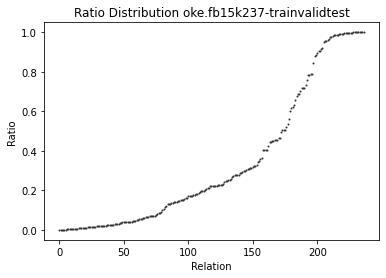

In [9]:
import ryn
from ryn.common import plotter

path = ryn.ENV.SPLIT_DIR / f'{g.name}.ratio'
path.parent.mkdir(exist_ok=True, parents=True)

plt = plotter.Plotter(title=f'Ratio Distribution {g.name}', xlabel='Relation', ylabel='Ratio', fname=str(path))
plt.ax.scatter(range(len(rels)), [r.ratio for r in rels], color=plotter.CLR[0], s=1)

print()
plt.plot()
print()

In [8]:
import ryn

rows = []
for i in range(1, 15):
    cfg = split.Config(
        owcw_split=0.7,
        trainvalid_split=0.7,
        threshold=i * 10)

    print(f'creating a hard split, keeping concepts of {cfg.threshold} relations')
    for stats in split.create(g, cfg, rels, seeds):
        rows.append(stats)

split.stats_rows(ryn.ENV.SPLIT_DIR, rows)

creating a hard split, keeping concepts of 10 relations


done
creating a hard split, keeping concepts of 20 relations


done
creating a hard split, keeping concepts of 30 relations


done
creating a hard split, keeping concepts of 40 relations


done
creating a hard split, keeping concepts of 50 relations


done
creating a hard split, keeping concepts of 60 relations


done
creating a hard split, keeping concepts of 70 relations


done
creating a hard split, keeping concepts of 80 relations


done
creating a hard split, keeping concepts of 90 relations


done
creating a hard split, keeping concepts of 100 relations


done
creating a hard split, keeping concepts of 110 relations


done
creating a hard split, keeping concepts of 120 relations


done
creating a hard split, keeping concepts of 130 relations


done
creating a hard split, keeping concepts of 140 relations


done
